## Advanced Control Methods | Assignment 1

### Introduction&theory recap

This assignment is devoted to the implementation of an estimator - a neural network, that predicts the next state basing on the current state and current control. Specifically,

$x_k$ - state from state space $\mathbb{X}$

$u_k$ - action from action space $\mathbb{U}$,

and we are interested in **learning** a function *e* (estimator) such that

$x_{k+1} = e(x_k, u_k)$

We will perform that via gradient gescent (with the help of pytorch), calculating the loss on a sliding buffer of the recent states and actions.

### Grading, submission&other

The first part of the notebook, starting from the `rcognita` installation, should not be changed. It demonstrates the objects and methods that are directly involved in the simulation process.

Auto-grading cells are here to save the robot's trajectory into a `.json` file, that you are supposed to submit. The grading policy 

### Problems

The assignment consists of two parts. Both of them are devoted to the learnable next estimator. The first one is (for speeding up the calculations)

The notebook runs the whole simulation out of the box. You are supposed to insert your code in four places in the notebook that are marked with a comment saying so. Those places are:
- `update_params` of the `EstimatorRNN` class: please provide the necessary code for the learning of the model
- `output_loss` of the same class: please implement the loss calculation for all the buffer; use criterion and buffers that are already present
- `no_playback` of the `Animator3WRobotNI_estimator` class: send proper observation and action to the estimator, extract estimator loss, and call the estimator updating function.
- Create 

NNs

check loss decay on fixed buffer


Let us install the framework for simulation and visualization

In [1]:
!pip install rcognita

You should consider upgrading via the '/usr/local/opt/python@3.9/bin/python3.9 -m pip install --upgrade pip' command.


Defines and imports

In [55]:
notebook_name = "main_3wrobot_NI.ipynb"

import os, sys
__file__ = os.path.join(os.getcwd(),notebook_name)
PARENT_DIR = os.path.abspath(__file__ + '/../..')
sys.path.insert(0, PARENT_DIR)

import rcognita

if os.path.abspath(rcognita.__file__ + "/../..") == PARENT_DIR:
    info = f"this script is being run using " \
           f"rcognita ({rcognita.__version__}) " \
           f"located in cloned repository at '{PARENT_DIR}'. " \
           f"If you are willing to use your locally installed rcognita, " \
           f"run this script ('{os.path.basename(__file__)}') outside " \
           f"'rcognita/presets'."
else:
    info = f"this script is being run using " \
           f"locally installed rcognita ({rcognita.__version__}). " \
           f"Make sure the versions match."
print("INFO:", info)

import pathlib
    
import warnings
import csv
from datetime import datetime
import matplotlib.animation as animation
import matplotlib.pyplot as plt
import numpy as np

from rcognita import simulator
from rcognita import systems
from rcognita import controllers
from rcognita import loggers
from rcognita import visuals
from rcognita import estimators
from rcognita.utilities import on_key_press
from argparser_3wrobot_NI import parser
import importlib
import json
import rcognita.models as models

from rcognita.utilities import push_vec

import torch
import torch.optim as optim
import torch.nn as nn

%matplotlib notebook
%load_ext autoreload
%autoreload 2

INFO: this script is being run using rcognita (v0.1.2) located in cloned repository at '/Users/elijah/Documents/edu-2022-safeAI/assignments/asgn-1/rcognita'. If you are willing to use your locally installed rcognita, run this script ('main_3wrobot_NI.ipynb') outside 'rcognita/presets'.
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Setting configuration and arguments

In [56]:
dim_state = 3
dim_input = 2
dim_output = dim_state
dim_disturb = 0

dim_R1 = dim_output + dim_input
dim_R2 = dim_R1

args = parser.parse_args(["--is_visualization", "True"])

if not isinstance(args.state_init[0], int):
    for k in range(len(args.state_init)):
        args.state_init[k] = eval( args.state_init[k].replace('pi', str(np.pi)) )

args.state_init = np.array(args.state_init)
args.action_manual = np.array(args.action_manual)

pred_step_size = args.dt * args.pred_step_size_multiplier
model_est_period = args.dt * args.model_est_period_multiplier
critic_period = args.dt * args.critic_period_multiplier

R1 = np.diag(np.array(args.R1_diag))
R2 = np.diag(np.array(args.R2_diag))

assert args.t1 > args.dt > 0.0
assert args.state_init.size == dim_state

globals().update(vars(args))

In [57]:
is_disturb = 0
is_dyn_ctrl = 0

t0 = 0

action_init = 0 * np.ones(dim_input)

# Solver
atol = 1e-5
rtol = 1e-3

# xy-plane
xMin = -10
xMax = 10
yMin = -10
yMax = 10

# Model estimator stores models in a stack and recall the best of model_est_checks
model_est_checks = 0

# Control constraints
v_min = -25
v_max = 25
omega_min = -5
omega_max = 5
ctrl_bnds=np.array([[v_min, v_max], [omega_min, omega_max]])

Defining system, controller and simulator. Dumping parameters

In [58]:
my_sys = systems.Sys3WRobotNI(sys_type="diff_eqn",
                                     dim_state=dim_state,
                                     dim_input=dim_input,
                                     dim_output=dim_output,
                                     dim_disturb=dim_disturb,
                                     pars=[],
                                     ctrl_bnds=ctrl_bnds,
                                     is_dyn_ctrl=is_dyn_ctrl,
                                     is_disturb=is_disturb,
                                     pars_disturb=[])

observation_init = my_sys.out(state_init)

xCoord0 = state_init[0]
yCoord0 = state_init[1]
alpha0 = state_init[2]
alpha_deg_0 = alpha0/2/np.pi

In [59]:
my_ctrl_nominal = controllers.CtrlNominal3WRobotNI(ctrl_gain=0.5, ctrl_bnds=ctrl_bnds, t0=t0, sampling_time=dt)

# Predictive optimal controller
my_ctrl_opt_pred = controllers.CtrlOptPred(dim_input,
                                           dim_output,
                                           ctrl_mode,
                                           ctrl_bnds = ctrl_bnds,
                                           action_init = [],
                                           t0 = t0,
                                           sampling_time = dt,
                                           Nactor = Nactor,
                                           pred_step_size = pred_step_size,
                                           sys_rhs = my_sys._state_dyn,
                                           sys_out = my_sys.out,
                                           state_sys = state_init,
                                           prob_noise_pow = prob_noise_pow,
                                           is_est_model = is_est_model,
                                           model_est_stage = model_est_stage,
                                           model_est_period = model_est_period,
                                           buffer_size = buffer_size,
                                           model_order = model_order,
                                           model_est_checks = model_est_checks,
                                           gamma = gamma,
                                           Ncritic = Ncritic,
                                           critic_period = critic_period,
                                           critic_struct = critic_struct,
                                           stage_obj_struct = stage_obj_struct,
                                           stage_obj_pars = [R1],
                                           observation_target = [])

my_ctrl_benchm = my_ctrl_opt_pred

In [60]:
my_simulator = simulator.Simulator(sys_type = "diff_eqn",
                                   closed_loop_rhs = my_sys.closed_loop_rhs,
                                   sys_out = my_sys.out,
                                   state_init = state_init,
                                   disturb_init = [],
                                   action_init = action_init,
                                   t0 = t0,
                                   t1 = t1,
                                   dt = dt,
                                   max_step = dt/2,
                                   first_step = 1e-6,
                                   atol = atol,
                                   rtol = rtol,
                                   is_disturb = is_disturb,
                                   is_dyn_ctrl = is_dyn_ctrl)

In [61]:
if os.path.basename( os.path.normpath( os.path.abspath(os.getcwd()) ) ) == 'presets':
    data_folder = '../simdata'
else:
    data_folder = 'simdata'

pathlib.Path(data_folder).mkdir(parents=True, exist_ok=True) 

date = datetime.now().strftime("%Y-%m-%d")
time = datetime.now().strftime("%Hh%Mm%Ss")
datafiles = [None] * Nruns

for k in range(0, Nruns):
    datafiles[k] = data_folder + '/' + my_sys.name + '__' + ctrl_mode + '__' + date + '__' + time + '__run{run:02d}.csv'.format(run=k+1)
    
    if is_log_data:
        print('Logging data to:    ' + datafiles[k])
            
        with open(datafiles[k], 'w', newline='') as outfile:
            writer = csv.writer(outfile)
            writer.writerow(['System', my_sys.name ] )
            writer.writerow(['Controller', ctrl_mode ] )
            writer.writerow(['dt', str(dt) ] )
            writer.writerow(['state_init', str(state_init) ] )
            writer.writerow(['is_est_model', str(is_est_model) ] )
            writer.writerow(['model_est_stage', str(model_est_stage) ] )
            writer.writerow(['model_est_period_multiplier', str(model_est_period_multiplier) ] )
            writer.writerow(['model_order', str(model_order) ] )
            writer.writerow(['prob_noise_pow', str(prob_noise_pow) ] )
            writer.writerow(['Nactor', str(Nactor) ] )
            writer.writerow(['pred_step_size_multiplier', str(pred_step_size_multiplier) ] )
            writer.writerow(['buffer_size', str(buffer_size) ] )
            writer.writerow(['stage_obj_struct', str(stage_obj_struct) ] )
            writer.writerow(['R1_diag', str(R1_diag) ] )
            writer.writerow(['R2_diag', str(R2_diag) ] )
            writer.writerow(['Ncritic', str(Ncritic) ] )
            writer.writerow(['gamma', str(gamma) ] )
            writer.writerow(['critic_period_multiplier', str(critic_period_multiplier) ] )
            writer.writerow(['critic_struct', str(critic_struct) ] )
            writer.writerow(['actor_struct', str(actor_struct) ] )   
            writer.writerow(['t [s]', 'x [m]', 'y [m]', 'alpha [rad]', 'stage_obj', 'accum_obj', 'v [m/s]', 'omega [rad/s]'] )


In [62]:
class ModelRNN(nn.Module):
    def __init__(self, weights, dim_observation, dim_action, dim_hidden):
        super().__init__()
        
        self.criterion = nn.L1Loss()
        #self.criterion = nn.MSELoss()
        
        #############################################
        # YOUR CODE BELOW
        #############################################

        self.fc1   = nn.Linear(dim_observation + dim_action, dim_hidden)
        self.relu1 = nn.LeakyReLU()
        self.fc2   = nn.Linear(dim_hidden, dim_observation)
        
        #############################################
        # YOUR CODE ABOVE
        #############################################

        if (weights is not None):
            self.load_state_dict(weights)

        self.double()
        
    def forward(self, x):
        x = x.double()

        #############################################
        # YOUR CODE BELOW
        #############################################

        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        
        #############################################
        # YOUR CODE ABOVE
        #############################################
        
        return x

    def model_out(self, observation, action):
        """
        Output estimated observation
        """

        concat = np.concatenate((observation, action))
        to_torch = torch.tensor(concat)

        return self.forward(to_torch)

    def updateIC(self, observation_est_init_new):
        """
        Update initial condition
        """

        self.observation_est_init = observation_est_init_new
        
    def output_loss(self, observation, action, true_next_obs):
        """
        Return current loss
        """

        self.loss = 0

        observation_pred = self.model_out(observation, action)
        self.loss = self.criterion(observation_pred, torch.tensor(true_next_obs))
        
        return self.loss.detach().numpy()

class ModelRNN_deeper(nn.Module):
    def __init__(self, weights, dim_observation, dim_action, dim_hidden):
        super().__init__()
        
        #self.criterion = nn.L1Loss()
        self.criterion = nn.MSELoss()
        
        #############################################
        # YOUR CODE BELOW
        #############################################

        self.fc1   = nn.Linear(dim_observation + dim_action, dim_hidden)
        self.relu1 = nn.LeakyReLU()
        self.fc2   = nn.Linear(dim_hidden, dim_hidden)
        self.relu2 = nn.LeakyReLU()
        self.fc3   = nn.Linear(dim_hidden, dim_observation)
        
        #############################################
        # YOUR CODE ABOVE
        #############################################

        if (weights is not None):
            self.load_state_dict(weights)

        self.double()
        
    def forward(self, x):
        x = x.double()

        #############################################
        # YOUR CODE BELOW
        #############################################

        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.fc3(x)
        
        #############################################
        # YOUR CODE ABOVE
        #############################################
        
        return x

    def model_out(self, observation, action):
        """
        Output estimated observation
        """

        concat = np.concatenate((observation, action))
        to_torch = torch.tensor(concat)

        return self.forward(to_torch)

    def updateIC(self, observation_est_init_new):
        """
        Update initial condition
        """

        self.observation_est_init = observation_est_init_new
        
    def output_loss(self, observation, action, true_next_obs):
        """
        Return current loss
        """

        self.loss = 0

        observation_pred = self.model_out(observation, action)
        self.loss = self.criterion(observation_pred, torch.tensor(true_next_obs))
        
        return self.loss.detach().numpy()

In [8]:
from grading_utilities import load_from_json

#load data

#data = [[np.array([1.0, 2.0, 3.0]), np.array([4.0, 5.0])]]
dat = load_from_json("Osokin_Ilya_asgn_1.json")

<IPython.core.display.Javascript object>


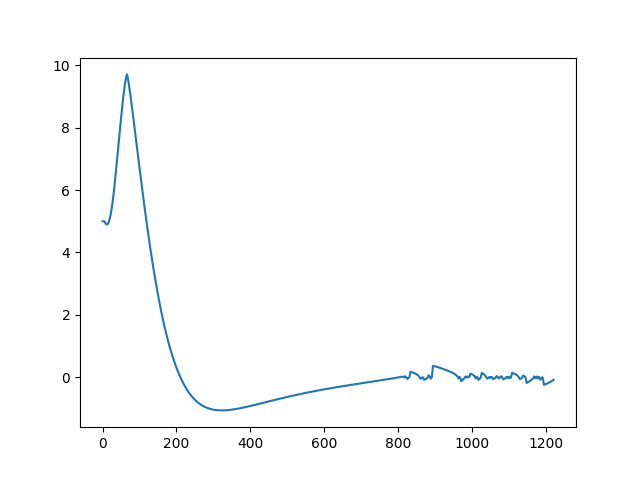

In [18]:
import matplotlib.pyplot as plt

traj = dat["trajectory_log"]["observation_action_traj"]

x = []
y = []

for i in range(len(traj)):
    x.append(traj[i][0][0])
    y.append(traj[i][0][1])

#print(x)

fig, ax = plt.subplots()  # Create a figure containing a single axes.
ax.plot(x)

data = []

for i in range(len(traj)):
    data.append([np.array(traj[i][0]), traj[i][1]])

#plt.plot(x)
#plt.show()

In [10]:
#exploding gradients
# https://neptune.ai/blog/understanding-gradient-clipping-and-how-it-can-fix-exploding-gradients-problem

model = ModelRNN_deeper(None, 3, 2, 30)

optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

#train loop
for _ in range(15):
    for i, (state, action) in enumerate(data[200:600]):
        optimizer.zero_grad()
        
        loss_val = model.output_loss(state, action, state)
        
        if (i % 10000 == 0):
            print(loss_val)
        
        model.loss.backward()
        
        nn.utils.clip_grad_value_(model.parameters(), clip_value=1.0)
        
        optimizer.step()

2.653217540934461
2.1733683726431323
1.8741284068709998
1.5599789290793595
1.2414133508849459
1.010185261221744
0.7271901863306144
0.6773988641138237
0.630225278991534
0.538277616747341
0.5593198765055089
0.4727307047453073
0.40724773114379237
0.3877567857839797
0.3645204706626384


In [11]:
for param in model.parameters():
    print(param.data)

tensor([[ 0.2282,  0.2978, -0.1125, -0.1352,  0.0600],
        [-0.2289, -0.0068,  0.0264,  0.2012, -0.3285],
        [-0.3234,  0.3896,  0.0081, -0.3066, -0.2106],
        [-0.2536,  0.2573, -0.3804, -0.0617,  0.2109],
        [-0.4028, -0.4194,  0.3813,  0.2529, -0.3098],
        [-0.0868, -0.3280,  0.2654,  0.3133, -0.0936],
        [ 0.0586, -0.4463, -0.3694, -0.3582, -0.2065],
        [ 0.2050,  0.0124,  0.1874, -0.3967,  0.1923],
        [ 0.1195,  0.3725, -0.0245, -0.2643,  0.0390],
        [-0.3156, -0.2886, -0.4127, -0.0352, -0.0535],
        [-0.1477,  0.1918, -0.3155, -0.0325, -0.3560],
        [-0.3419, -0.2295,  0.1705,  0.1233, -0.3975],
        [ 0.2116,  0.3397, -0.3662, -0.3883, -0.3796],
        [ 0.2863,  0.2058, -0.1346, -0.1428, -0.0522],
        [-0.4305,  0.4024, -0.3708, -0.2876, -0.1503],
        [-0.1295, -0.0876,  0.0173, -0.3266, -0.1750],
        [-0.1414, -0.4287, -0.1265, -0.1242,  0.3552],
        [ 0.3873,  0.2143,  0.0776,  0.2696, -0.2414],
        [ 

In [12]:
print("\033[92m{}\033[0m".format("asjchcsh"), "10.0")

asjchcsh 10.0


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<IPython.core.display.Javascript object>


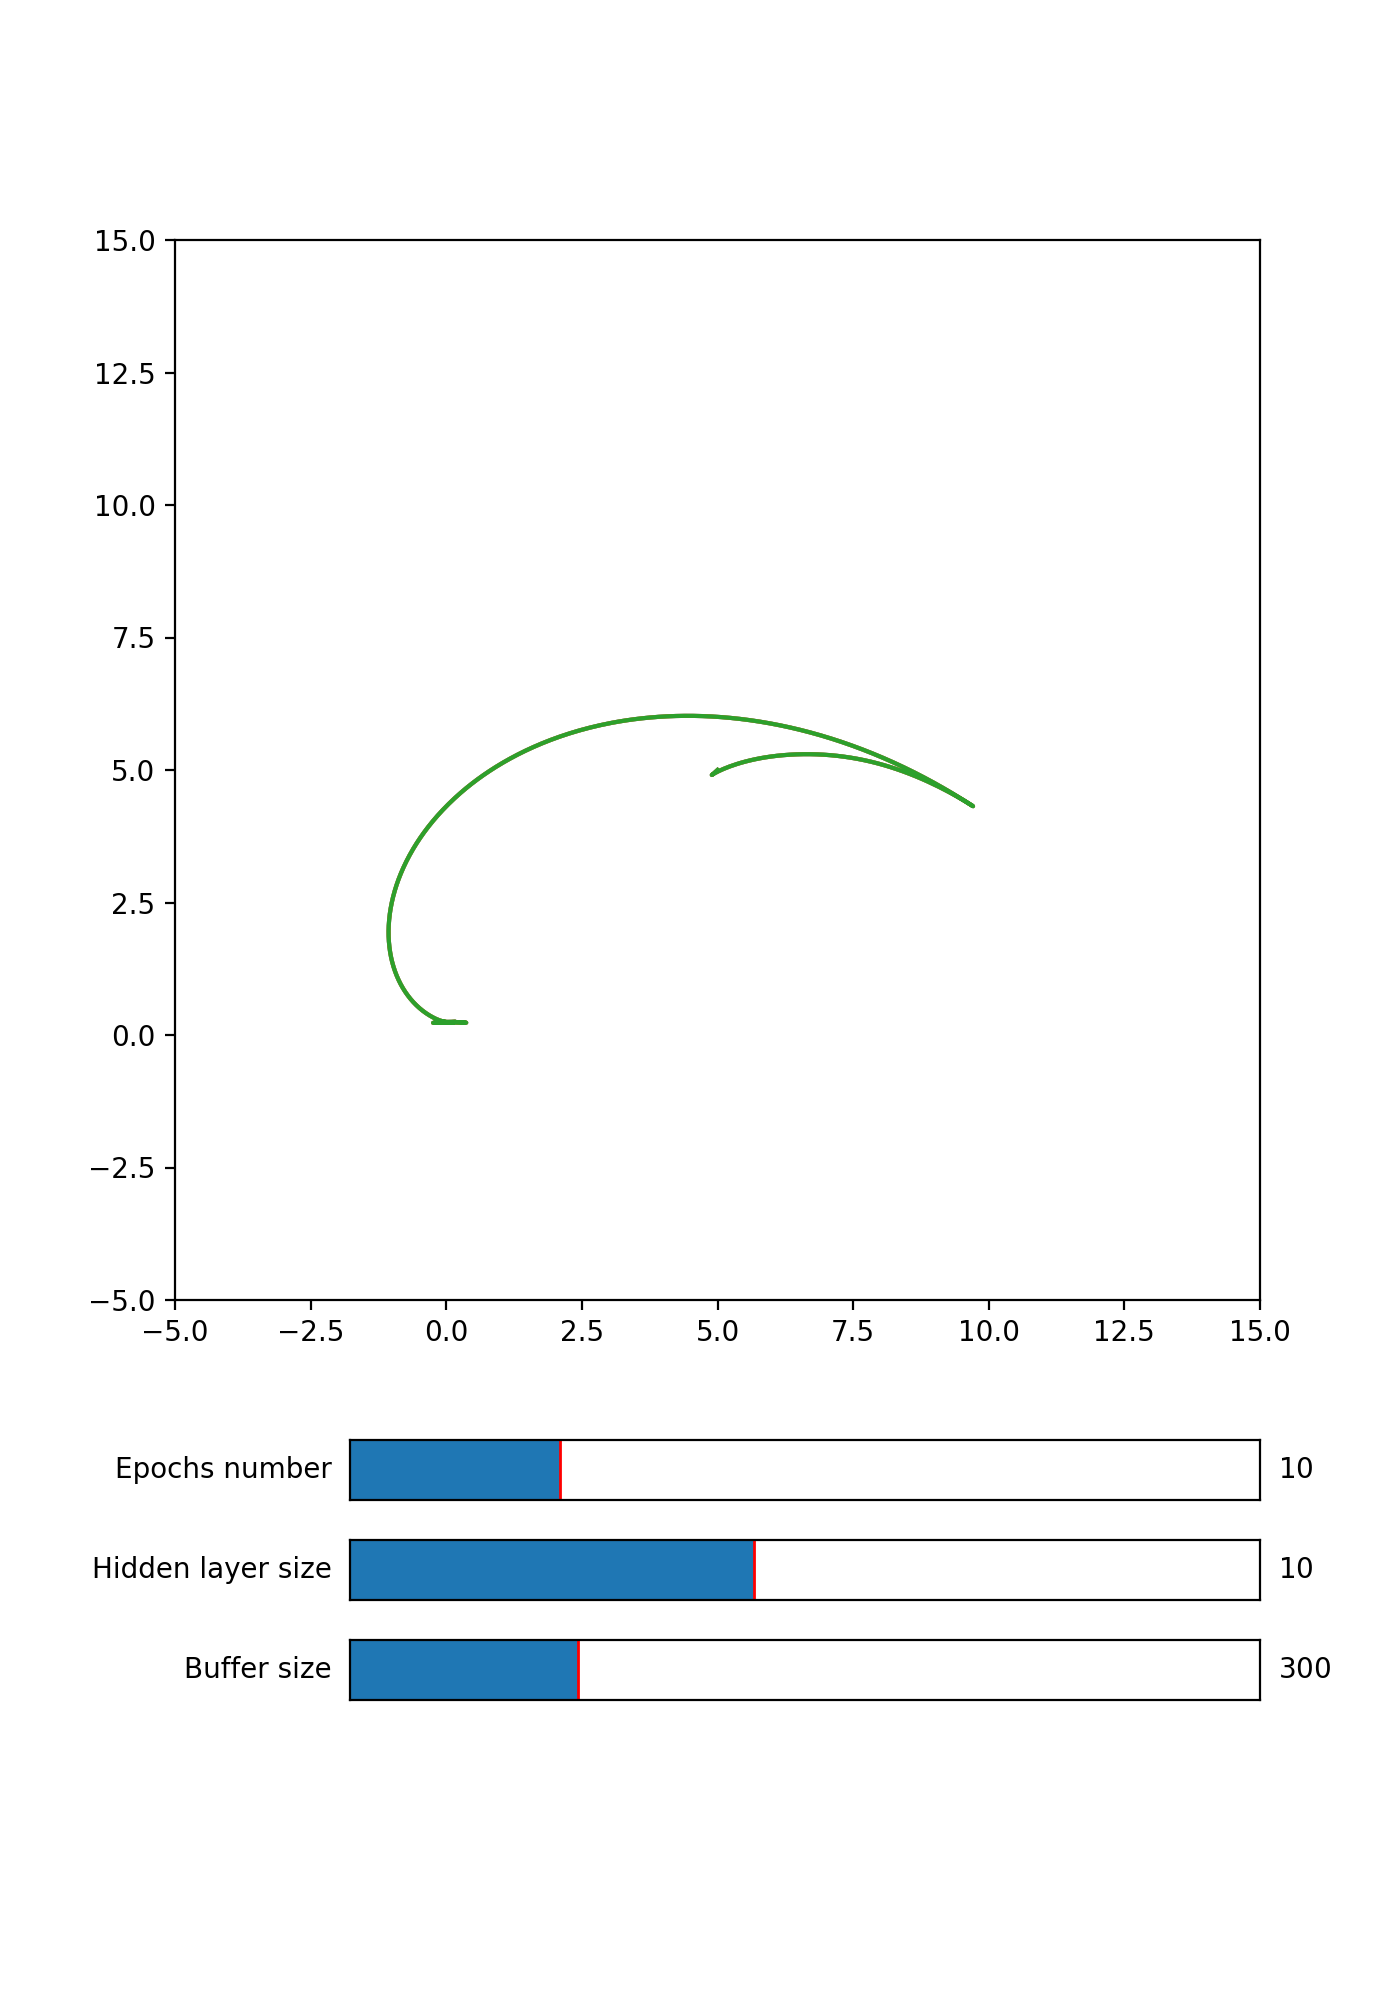

In [63]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider, Button

%matplotlib notebook
%load_ext autoreload
%autoreload 2

# Create subplot
fig, ax = plt.subplots(figsize=(7, 10))
plt.subplots_adjust(bottom=0.35)
plt.xlim([-5, 15])
plt.ylim([-5, 15])
 
true_traj1, = plt.plot(x, y)
true_traj2, = plt.plot(x, y)
pred_traj,  = plt.plot(x, y)
 
axbuff = plt.axes([0.25, 0.15, 0.65, 0.03])
axhidd = plt.axes([0.25, 0.20, 0.65, 0.03])
axepochs = plt.axes([0.25, 0.25, 0.65, 0.03])

buff = Slider(axbuff, 'Buffer size', 200, 600, 300)
hidd = Slider(axhidd, 'Hidden layer size', 2, 20, 10)
epochs = Slider(axepochs, 'Epochs number', 1, 40, 10)
 
def update(val):
    buffer_size = int(buff.val)
    hidden_layer_size = int(hidd.val)
    epochs_num = int(epochs.val)
    
    model = ModelRNN_deeper(None, 3, 2, hidden_layer_size)
    
    optimizer = optim.SGD(model.parameters(), lr=0.0005, momentum=0.9)
        
    BUF_SHIFT    = 100
    TEST_BUF_LEN = 500
    
    #train loop
    for _ in range(epochs_num):
        for i, (state, action) in enumerate(data[BUF_SHIFT : BUF_SHIFT + buffer_size]):
            optimizer.zero_grad()
            
            next_state, _ = data[BUF_SHIFT + i + 1]

            loss_val = model.output_loss(state, action, next_state)

            model.loss.backward()

            nn.utils.clip_grad_value_(model.parameters(), clip_value=1.0)

            optimizer.step()
    
    #############################
    x_curr = data[BUF_SHIFT][0][0]
    y_curr = data[BUF_SHIFT][0][1]
    
    pred_traj_x = []
    pred_traj_y = []
    
    for i in range(BUF_SHIFT, BUF_SHIFT + TEST_BUF_LEN):
        observation = data[i][0]
        action      = data[i][1]

#         observation[0] = x_curr
#         observation[1] = y_curr
        
        x_pred, y_pred = model.model_out(observation, action).detach().numpy()[:2]
        
        pred_traj_x.append(x_pred)
        pred_traj_y.append(y_pred)
        
        x_curr, y_curr = x_pred, y_pred
        
    true_traj1.set_xdata(x[:BUF_SHIFT])
    true_traj1.set_ydata(y[:BUF_SHIFT])

    true_traj2.set_xdata(x[BUF_SHIFT:])
    true_traj2.set_ydata(y[BUF_SHIFT:])

    pred_traj.set_xdata(pred_traj_x)
    pred_traj.set_ydata(pred_traj_y)

# Call update function when slider value is changed
buff.on_changed(update)
hidd.on_changed(update)
epochs.on_changed(update)
 
# display graph
plt.show()

In [2]:
class ModelRNN_deeper(nn.Module):
    def __init__(self, weights, dim_observation, dim_action, dim_hidden):
        super().__init__()
        
        #############################################
        # YOUR CODE BELOW
        #############################################

        self.fc1   = nn.Linear(dim_observation + dim_action, dim_hidden)
        self.relu1 = nn.LeakyReLU()
        self.fc2   = nn.Linear(dim_hidden, dim_hidden)
        self.relu2 = nn.LeakyReLU()
        self.fc3   = nn.Linear(dim_hidden, dim_hidden)
        self.relu3 = nn.LeakyReLU()
        self.fc4   = nn.Linear(dim_hidden, dim_observation)
        
        #############################################
        # YOUR CODE ABOVE
        #############################################

        if (weights is not None):
            self.load_state_dict(weights)

        self.double()

    def forward(self, x):
        x = x.double()

        #############################################
        # YOUR CODE BELOW
        #############################################

        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.fc3(x)
        x = self.relu3(x)
        x = self.fc4(x)
        
        #############################################
        # YOUR CODE ABOVE
        #############################################

        return x

    def model_out(self, observation, action):
        """
        Output estimated observation
        """

        concat = np.concatenate((observation, action))
        to_torch = torch.tensor(concat)

        return self.forward(to_torch)

    def updateIC(self, observation_est_init_new):
        """
        Update initial condition
        """

        self.observation_est_init = observation_est_init_new

NameError: name 'nn' is not defined

In [64]:
class EstimatorRNN:
    """
    Class of model estimators based on recurrent neural networks
    """

    def __init__(self, dim_observation, dim_action, dim_hidden, buffer_size, model = None, Nbackprops = 1):
        self.buffer_size = buffer_size

        self.dim_observation = dim_observation
        self.dim_action      = dim_action
        self.dim_hidden      = dim_hidden

        if (model is None):
            self.model = models.ModelRNN_deeper(None, self.dim_observation, self.dim_action, self.dim_hidden)

        else:
            self.model = model

        self.criterion = nn.L1Loss()
        #self.criterion = nn.MSELoss()

        self.optimizer = optim.SGD(self.model.parameters(), lr=0.002, momentum=0.9)

        self.observation_buffer = np.zeros((self.buffer_size, self.dim_observation), dtype = np.float64)
        self.action_buffer      = np.zeros((self.buffer_size, self.dim_action), dtype = np.float64)

        self.Nbackprops = Nbackprops
        
        self.last_pred = None

    def receive_sys_IO(self, observation, action):
        self.observation_buffer = push_vec(self.observation_buffer, observation)
        self.action_buffer      = push_vec(self.action_buffer, action)

    def update_params(self):
        """
        Update neural network weights
        """

        #############################################
        # YOUR CODE BELOW
        #############################################

        self.loss.backward()
        self.optimizer.step()
        
        #############################################
        # YOUR CODE ABOVE
        #############################################

    def get_last_pred(self):
        return self.last_pred
    
    def output_loss(self):
        """
        Return current loss
        """

        self.loss = 0
        self.optimizer.zero_grad()

        #############################################
        # YOUR CODE BELOW
        #############################################

        for i in range(self.buffer_size - 1):
            observation_pred = self.model.model_out(self.observation_buffer[i, :],
                                                    self.action_buffer[i, :])
            self.loss += self.criterion(observation_pred[:2],
                            torch.tensor(self.observation_buffer[i + 1, :2]))
            
            self.last_pred = observation_pred
        
        #############################################
        # YOUR CODE ABOVE
        #############################################    
        
        return self.loss.detach().numpy()

In [65]:
if is_print_sim_step:
    warnings.filterwarnings('ignore')
    
my_logger = loggers.Logger3WRobotNI()

model = ModelRNN(None, dim_output, dim_input, 7)

my_estimator = EstimatorRNN(dim_action = dim_input, dim_observation = dim_output,
                             dim_hidden = 10, buffer_size = 15, model = model)

In [68]:
observation_action_traj = []

class Animator3WRobotNI_WithEstimator(visuals.Animator3WRobotNI):
    def __init__(self, objects=[], pars=[]):
        super().__init__(objects, pars)
        
        self.action = action_init
    
    def no_playback(self):
        global observation_action_traj
        
        self.simulator.sim_step()

        t, state, observation, state_full = self.simulator.get_sim_step_data()

        estimator_loss = 0
        
        #############################################
        # YOUR CODE BELOW
        #############################################

        my_estimator.receive_sys_IO(observation, self.action)
        
        estimator_loss = my_estimator.output_loss()

        my_estimator.update_params()
        
        #############################################
        # YOUR CODE ABOVE
        #############################################
        
        last_pred = my_estimator.get_last_pred()
        
        action = self.ctrl_selector(t, observation, self.action_manual, self.ctrl_nominal,
                                    self.ctrl_benchmarking, self.ctrl_mode)

        action = np.array([3, 2])
        
        self.action = action
        
        observation_action_traj.append([list(observation), list(self.action)])
        
        self.sys.receive_action(action)
        self.ctrl_benchmarking.receive_sys_state(self.sys._state)
        self.ctrl_benchmarking.upd_accum_obj(observation, action)

        stage_obj = self.ctrl_benchmarking.stage_obj(observation, action)
        accum_obj = self.ctrl_benchmarking.accum_obj_val

        return t, state, observation, state_full, action, stage_obj, accum_obj, \
    estimator_loss, last_pred.detach().numpy()

## Main loop

<IPython.core.display.Javascript object>


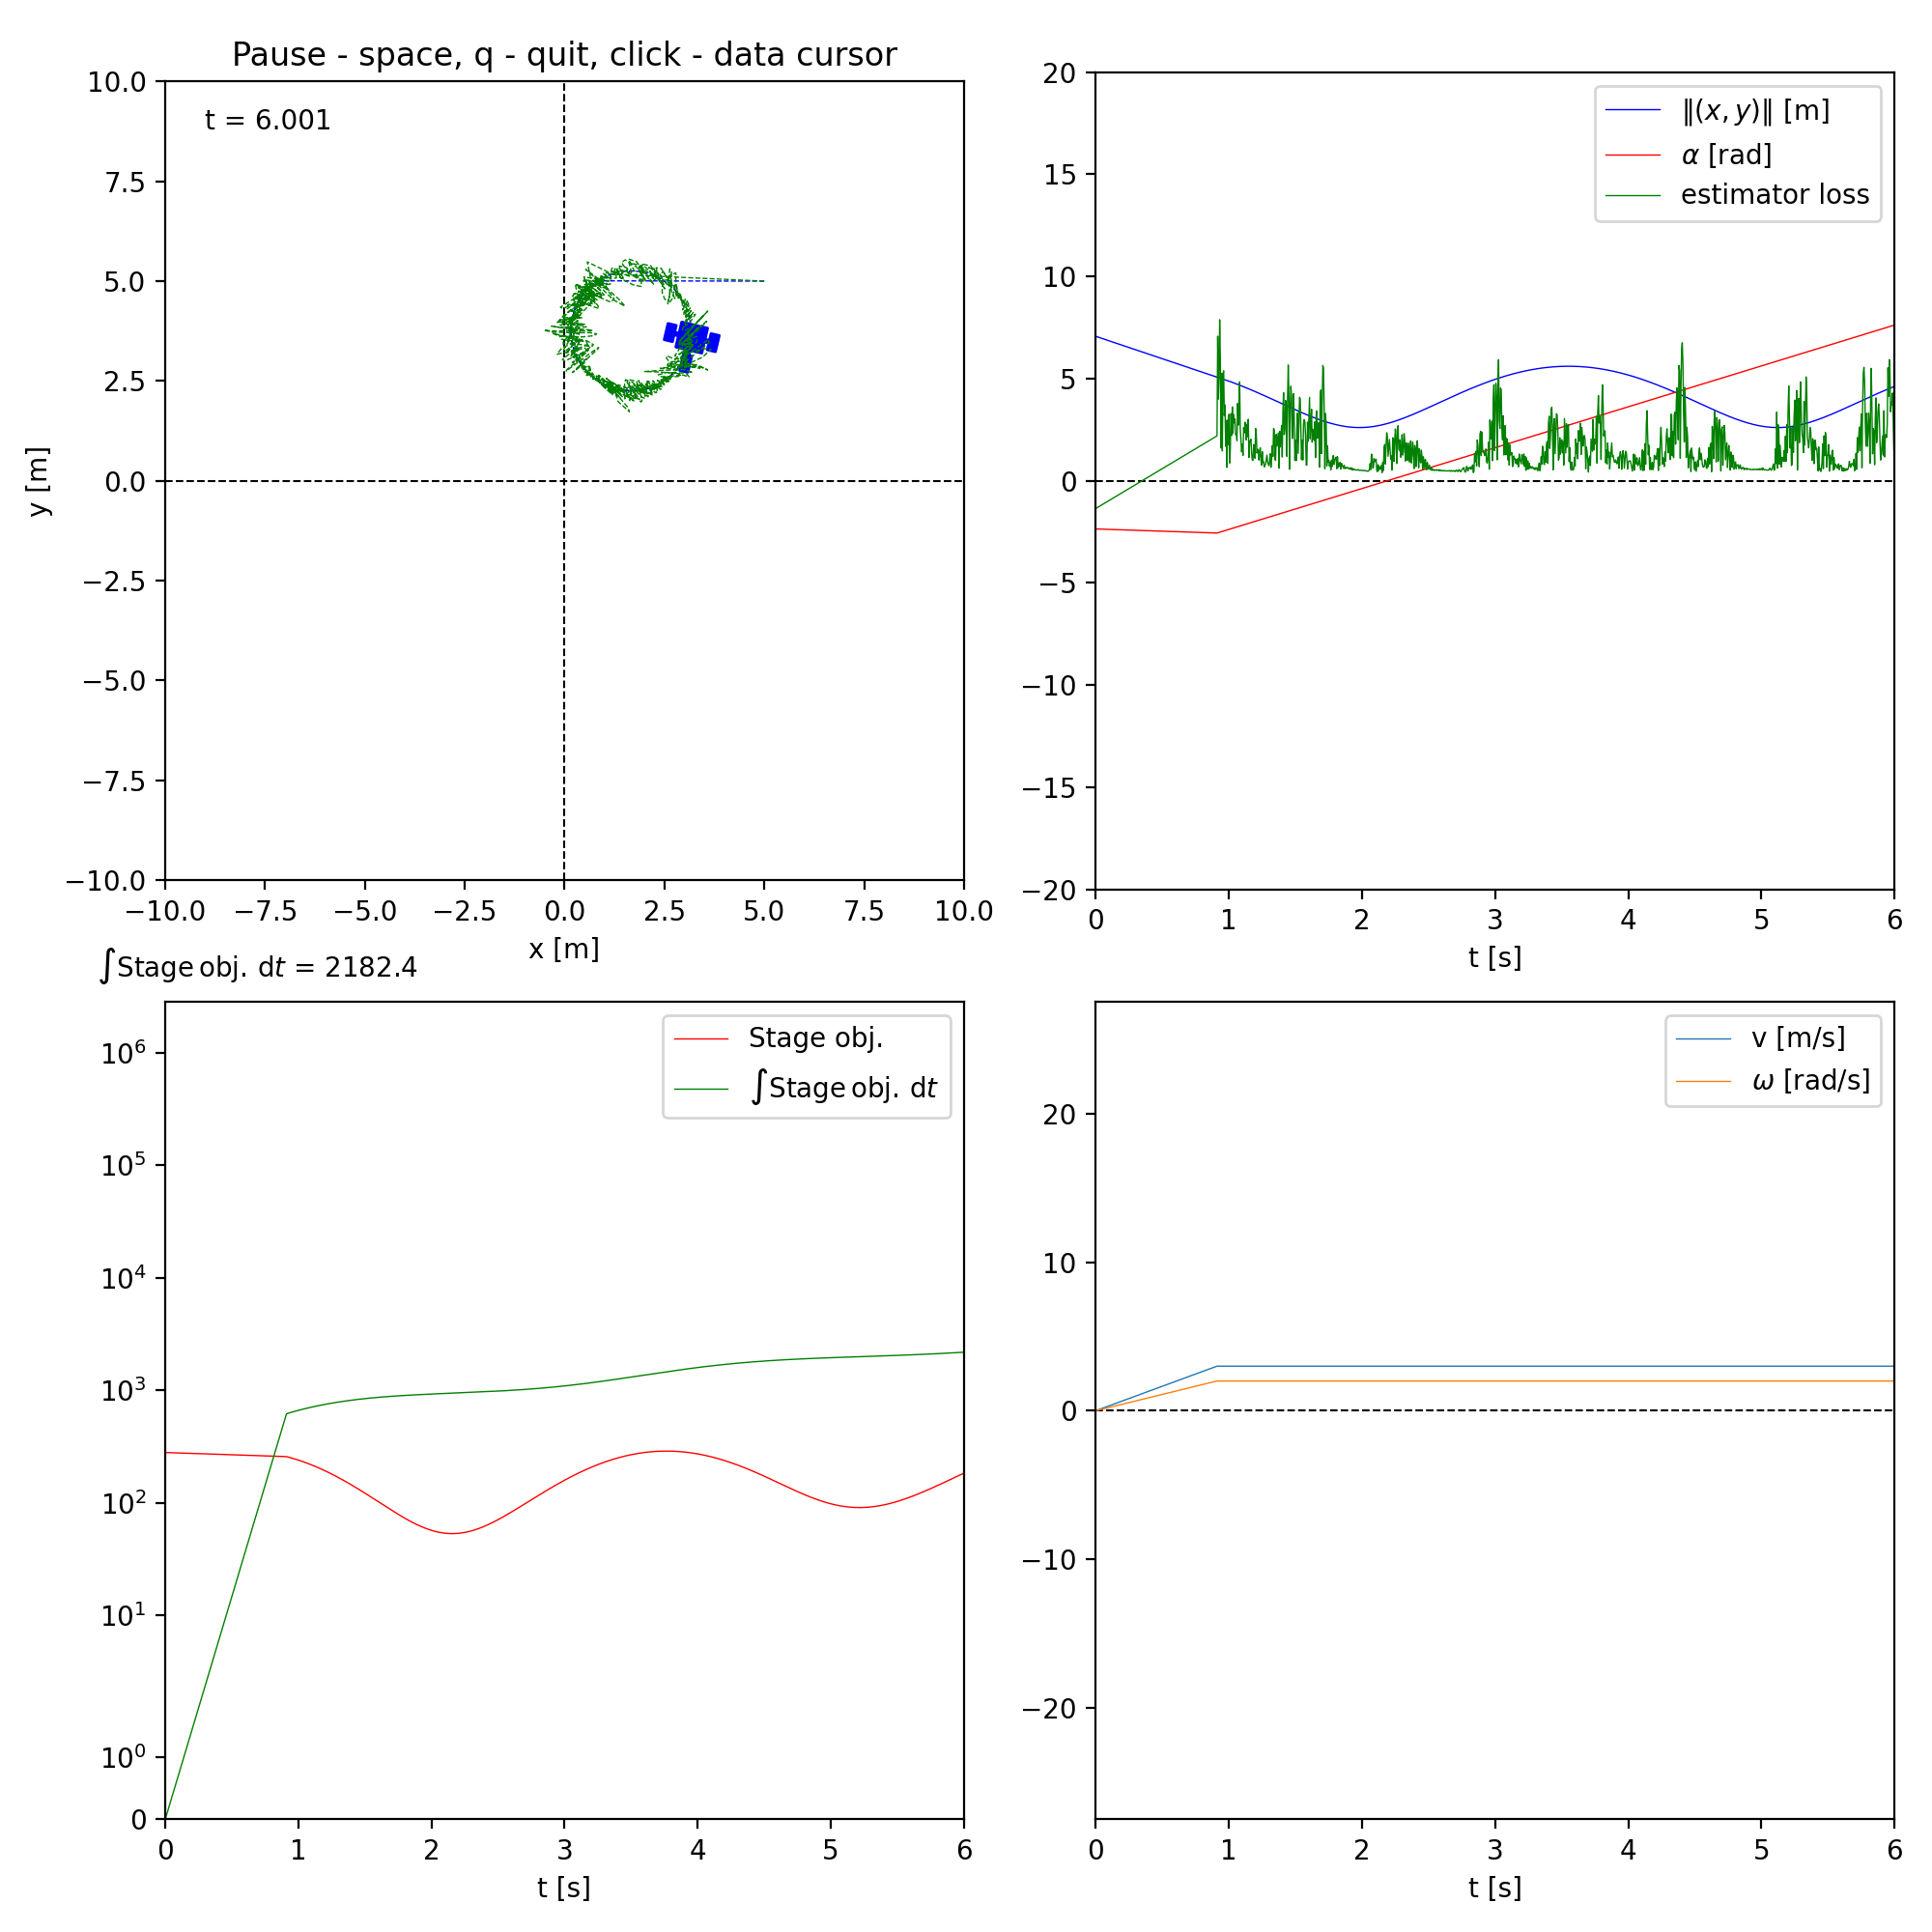

In [69]:
t1 = 6

if is_visualization:
    state_full_init = my_simulator.state_full
    
    my_animator = Animator3WRobotNI_WithEstimator(objects=(my_simulator,
                                                     my_sys,
                                                     my_ctrl_nominal,
                                                     my_ctrl_benchm,
                                                     datafiles,
                                                     controllers.ctrl_selector,
                                                     my_logger),
                                            pars=(state_init,
                                                  action_init,
                                                  t0,
                                                  t1,
                                                  state_full_init,
                                                  xMin,
                                                  xMax,
                                                  yMin,
                                                  yMax,
                                                  ctrl_mode,
                                                  action_manual,
                                                  v_min,
                                                  omega_min,
                                                  v_max,
                                                  omega_max,
                                                  Nruns,
                                                    is_print_sim_step, is_log_data, 0, []))

    anm = animation.FuncAnimation(my_animator.fig_sim,
                                  my_animator.animate,
                                  init_func=my_animator.init_anim,
                                  blit=False, interval=dt/1e6, repeat=False)
    
    my_animator.get_anm(anm)
    
    cId = my_animator.fig_sim.canvas.mpl_connect('key_press_event', lambda event: on_key_press(event, anm))
    
    anm.running = True
    
    my_animator.fig_sim.tight_layout()
    
    plt.show()

In [19]:
from grading_utilities import AnswerTracker

assignment_name = "asgn_1"
first_name = "Ilya" # Use proper capitalization
last_name = "Osokin" # Use proper capitalization

asgn1_answers = AnswerTracker()

asgn1_answers.record('trajectory_log', {'observation_action_traj': observation_action_traj})

asgn1_answers.save_to_json(assignment_name, first_name, last_name)

In [18]:
observation_action_traj

[[[5.0, 5.0, -2.356194490192345], [0.0, 0.0]],
 [[5.0, 5.0, -2.356194490192345], [0.0, 0.0]],
 [[5.0, 5.0, -2.356194490192345], [0.0, 0.0]],
 [[5.0, 5.0, -2.356194490192345], [0.0, 0.0]],
 [[5.0, 5.0, -2.356194490192345], [0.0, 0.0]],
 [[5.0, 5.0, -2.356194490192345], [7.5023487429992946, -5.0]],
 [[4.975614517281042, 4.976156478460493, -2.3789158443590117],
  [7.5023487429992946, -5.0]],
 [[4.948172827938363, 4.950582833510707, -2.4039158443590116],
  [4.457755057966343, -5.0]],
 [[4.930465937105981, 4.934866593746246, -2.4289158443590115],
  [4.457755057966343, -5.0]],
 [[4.913421524373367, 4.920505130568469, -2.4539158443590114],
  [1.4618909178751593, -5.0]],
 [[4.906660938241046, 4.915069964798872, -2.4789158443590114],
  [1.4618909178751593, -5.0]],
 [[4.900842933600692, 4.910645468698521, -2.5039158443590113],
  [1.4618909178751593, -5.0]],
 [[4.894916146111352, 4.906367790146618, -2.528915844359011],
  [-2.7007682939995803, -5.0]],
 [[4.904507714150767, 4.912903490665926, -2.55